In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import word2vec
import re 

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
from itertools import chain


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
!pip install spacy

In [3]:
!pip install nltk

In [4]:
#!pip uninstall stem

In [5]:
!pip install word2vec

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arturo.reyeslopez\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# From https://dictionary.cambridge.org/grammar/british-grammar/word-formation/prefixes
english_prefixes = {
"anti": "",    # e.g. anti-goverment, anti-racist, anti-war
"auto": "",    # e.g. autobiography, automobile
"bio": "",     # e.g. life, living matter
#"de": "",      # e.g. de-classify, decontaminate, demotivate
"dis": "",     # e.g. disagree, displeasure, disqualify
"down": "",    # e.g. downgrade, downhearted
"extra": "",   # e.g. extraordinary, extraterrestrial
"hyper": "",   # e.g. hyperactive, hypertension
#"il": "",     # e.g. illegal
#"im": "",     # e.g. impossible
#"in": "",     # e.g. insecure
#"ir": "",     # e.g. irregular
"inter": "",  # e.g. interactive, international
"mega": "",   # e.g. megabyte, mega-deal, megaton
"mid": "",    # e.g. midday, midnight, mid-October
"mis": "",    # e.g. misaligned, mislead, misspelt
"non": "",    # e.g. non-payment, non-smoking
"over": "",  # e.g. overcook, overcharge, overrate
"out": "",    # e.g. outdo, out-perform, outrun
"post": "",   # e.g. post-election, post-warn
"pre": "",    # e.g. prehistoric, pre-war
"pro": "",    # e.g. pro-communist, pro-democracy
#"re": "",     # e.g. reconsider, redo, rewrite
"semi": "",   # e.g. semicircle, semi-retired
"sub": "",    # e.g. submarine, sub-Saharan
"super": "",   # e.g. super-hero, supermodel
"tele": "",    # e.g. television, telephathic
"trans": "",   # e.g. transatlantic, transfer
"ultra": "",   # e.g. ultra-compact, ultrasound
#"un": "",      # e.g. under-cook, underestimate
"up": "",      # e.g. upgrade, uphill
}

In [8]:
import re
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [9]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [10]:
##Get average sentence vector
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    for word in words:
        #print("avg_sentence_vector word: ",word)
        #print("avg_sentence_vector words: ",words)
        #print("avg_sentence_vector index2word_set: ",index2word_set)
        if any(word in s for s in index2word_set):
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [11]:
def change_string(x):
    return x.lower().replace('.', ' ').replace('-',' ').replace("'", ' ').replace('/',' ').replace('&',' ').replace('(','').replace(')','').replace('?','')

In [12]:
#def change_string(s):
#    return re.sub(r'[^\w\s]','',s).lower()

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arturo.reyeslopez\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Filter out stopwords
# Receives tokenized words
def stop_words(word_tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in word_tokens if not w in stop_words]

In [15]:
#Flatten one level of nesting
def flatten(listOfLists):
    return list(chain.from_iterable(listOfLists))

In [16]:
def listOfLists(list):
    return list(map(lambda el:[el], lst)) 

In [17]:
def stemall(tokens):
    ps = PorterStemmer()
    return flatten([ [ ps.stem(word) for word in line.split(" ")] for line in tokens ])

In [18]:
#Recives a list of words
#Returns a list of prefixes and steam words
def stem_prefix(company, prefixes):
    comp=[]
    for word in company:
        for prefix in sorted(prefixes, key=len, reverse=True):
            # Use subn to track the no. of substitution made.
            # Allow dash in between prefix and root. 
            word, nsub = re.subn("{}[\-]?".format(prefix), "", word)
            if nsub > 0:
                comp.append(prefix)
        comp.append(porter.stem(word))
    return comp

In [19]:
#Receives a list of words
#Returns a list of prefixes and list of steam words
def porter_english_plus(companiesList, prefixes=english_prefixes):
    coList=[]
    
    for company in companiesList:
        coList.append(stem_prefix(company, prefixes))
    
    return coList

In [20]:
#Search new words to compare against the dataset are included in the vocabulary. 
#Otherwise, Include them to calculate vectors
def searchVocab(words):
    vocab=[]
    for word in words:
        try:
            word2vec_model[word]
        except:
            vocab.append(word)
    return vocab

In [21]:
import word2vec

In [22]:
#list of words
#Clean words:
    #1) Removing characters such as .,-,/, etc
    #2) Lowering case
    #3) Creating tokens
    #4) Deleting stop words
    #5) Separate prefixes
    #5) Stemming tokens
def preprocessing(words):
    #1,2,3,4
    tokens= list(map(stop_words,list(map(nltk.word_tokenize, list(map(lambda x: change_string(x), words))))))
    
    #5
    toks= porter_english_plus(tokens)
    
    ps = PorterStemmer()
    
    #6)
    return list(map(lambda x: [ps.stem(y) for y in x], toks))

In [23]:
#Read dataset:
def readFileToDataFrame(fileName):
    return pd.read_csv(fileName, usecols = ['name'])


In [24]:
#Process dataset sent as dataframe:
def preprocess(df):
    words=[]
    words= df['name'].values.tolist()
    
    prepWords= preprocessing(words)
    
    prepWords= [list(filter(None, lst)) for lst in prepWords]
    
    data_transposed = zip(prepWords)
    df = pd.DataFrame(data_transposed, columns=["name"])
    
    df2 = df['name']
    
    return prepWords, df2

In [25]:
def trainModel(prepWords):
    prepWords=flatten(prepWords)
    
    prepWords= [i for i in prepWords if i] 
    
    prepWords= [[el] for el in prepWords]
    
    #Training model using preprocessed data
    word2vec_model = Word2Vec(prepWords,size=100, window=1, min_count=1, workers=7)

    #Summarize vocabulary
    words = list(word2vec_model.wv.vocab)
    
    return word2vec_model

In [26]:
df= readFileToDataFrame('name-submission-sample.csv')

col_names =  ['name', 'avg_vector']
df2 = pd.DataFrame(col_names)

prepWords, df2= preprocess(df)

word2vec_model= trainModel(prepWords)

df['avg_vector']=df2.apply(lambda row : avg_sentence_vector(row, model=word2vec_model, num_features=100, index2word_set=set(word2vec_model.wv.index2word)).tolist())

##Saving name and vector values in file
df.to_csv('name-submission-vectors.csv',encoding='utf-8', index=False)

words = list(word2vec_model.wv.vocab)


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [27]:
from scipy import spatial
from gensim.models import KeyedVectors

#ORIGINAL 4 PAWS ONLY PET SERVICE
#get average vector for a new company
#company = "SMOKERY-FLURER" #1.0
#company = "PAWS 4 PET SERVICE" #Google:0.95, Word2Vec model:  1.0
#company = "PAWS FOR ONLY PET" #0.80 0.77193
#company = "PAWS FOR ONLY PETS" #0.80 0.77193  
#company = "POS FOR PET" POS is not in the vocabulary
#company ="VICTORIA INSTITUTE BIO CHEMICAL" #1.0 VICTORIA INSTITUTE BIOCHEMICAL
#company ="VICTORIA INSTITUTE'S BIO-CHEMICAL"
company = "AIR TWO RENTAL SOLUTIONS" #0.745764

#company= "FALLEN TRACTOR SERVICES"#0.701912

words=[]
words.append(company)

prepWords= preprocessing(words)

#Before query words in vocabulary and returns the words needed to be included in the vocabulary
prepWords=flatten(prepWords)

prepWords=[i for i in prepWords if i] 

vocab= searchVocab(prepWords)

#If needed add word to vocabulary
if len(vocab) > 0:
    pwords=[]
    df= readFileToDataFrame('name-submission-sample.csv')
    pwords, df2= preprocess(df)
    pwords.append(vocab)
    word2vec_model= trainModel(pwords)    
    #Calculating average vector for each company name:
    df['avg_vector']=df2.apply(lambda row : avg_sentence_vector(row, model=word2vec_model, num_features=100, index2word_set=set(word2vec_model.wv.index2word)).tolist())
    #Saving name and vector values in file
    df.to_csv('name-submission-vectors.csv',encoding='utf-8', index=False)

df = pd.read_csv('name-submission-vectors.csv', usecols = ['name','avg_vector'])
df['avg_vector']=df['avg_vector'].apply(lambda s: [float(x.strip(' []')) for x in s.split(',')])

company_avg_vector = avg_sentence_vector(prepWords, model=word2vec_model, num_features=100, index2word_set=set(word2vec_model.wv.index2word))

df['similarity']=df['avg_vector'].apply(lambda row : 1 - spatial.distance.cosine(row, company_avg_vector))

s= df['similarity'].max()
print("Similarity:",s)

df3= df.loc[df['similarity']== s]
print(df3)


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Similarity: 0.7094977927166415
                         name  \
200  AIR ONE RENTAL SOLUTIONS   

                                            avg_vector  similarity  
200  [-0.0011162118753418326, -0.000350227172020822...    0.709498  


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [28]:
print(word2vec_model['victoria'])

[ 1.3963638e-03  4.6399320e-04 -4.9699643e-03  2.0420838e-03
  1.9300794e-03 -3.4739713e-03 -2.7595055e-03  2.3062478e-03
  8.7180140e-04  4.0423698e-03  1.2479855e-03  5.8313517e-04
 -1.5383577e-03 -2.6040287e-03  1.6459640e-03 -3.8143063e-03
 -2.1353024e-03 -1.5193474e-03 -3.2203919e-03  3.6274979e-03
  3.4296643e-03 -1.2912253e-04 -3.3287953e-03 -3.0818693e-03
 -4.4888598e-03  1.1256869e-03  3.4745364e-03  3.3288817e-03
  2.1306251e-03 -3.0439286e-03  3.1263740e-03  4.5702513e-03
 -1.4839541e-03 -3.1438514e-03 -3.3757936e-03 -3.6420298e-03
  1.5927656e-03  2.3743277e-03  6.8451028e-04  2.9976715e-03
 -4.4293082e-04 -1.2936372e-04  2.3245756e-03 -7.4534881e-04
  1.8928342e-03  2.2524861e-03 -2.3959330e-03 -7.2577159e-04
  1.8328321e-03 -2.4921345e-03 -4.9958406e-03 -4.5892545e-03
  4.7555692e-03 -4.0869005e-03 -7.4510305e-04 -2.1703027e-03
 -8.9334435e-04 -3.8920208e-03  3.3479135e-03 -2.5414904e-03
  2.2900642e-03 -3.4034629e-03 -3.9268075e-03 -4.9008057e-04
 -1.9636021e-03  3.95056

C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [29]:
words = list(word2vec_model.wv.vocab)
print(words)

['r', 'f', 'n', 'contract', 'splash', 'beauti', 'studio', 'ltd', 'fabl', 'clean', 'co', 'mainland', 'tank', 'servic', 'harrison', 'develop', 'corpor', 'strate', 'scape', 'tight', 'line', 'fish', 'charter', 'westwat', 'thechimneyguy', 'chimney', '2008', 'enterpri', 'cottonwood', 'tree', 'emporium', 'westform', 'kevin', 'mitchel', 'construct', 'inc', 'inter', 'ior', 'drywood', 'initi', 'elip', 'consult', 'coal', 'valley', 'metal', 'recycl', 'greenwood', 'gourmet', 'mushroom', 'b', 'c', 'blacklin', 'form', 'chida', 'technolog', 'ward', 'up', 'gro', 'health', 'system', 'strategi', 'okonlin', 'info', 'softwar', 'l', 'dare', 'compani', 'z', 'excav', 'log', 'dj', 'pro', 'duct', 'sabiston', 'builder', 'uniqu', 'integr', 'well', 'ladner', 'storag', 'real', 'time', 'graphic', 'wrap', 'insul', 'market', 'mc', 'mainten', 'new', 'view', 'yaskar', 'sea', 'marin', 'electr', 'octan', 'help', 'hand', 'senior', 'care', 'mediar', 'dvd', 'canada', 'camprv', 'rental', 'alemb', 'heal', 'art', 'centr', 'et',

In [30]:
#print (word2vec_model.similarity('bio', 'biochem'))

In [31]:
#print (word2vec_model.most_similar(positive=['biochem'], negative=[], topn=4))

C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


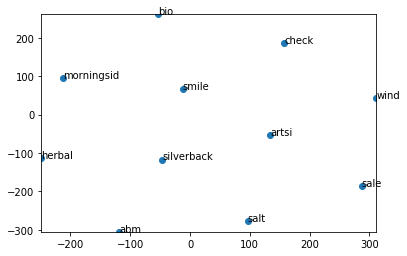

In [32]:
display_closestwords_tsnescatterplot(word2vec_model, 'bio', 100)
